# Assignment 2

This assignment is about training and evaluating a POS tagger with some real data. The dataset is available through NLTK, a Python NLP package.

**Part 1** (no actions required)

The dataset is composed of a set of sentences. Each sentence is a list of tuples of a word and a tag, as provided by human annotators.
You should split the data to train and test sets in the following way:


In [ ]:
from time import time
import matplotlib.pyplot as plt
from tabulate import tabulate
import pandas as pd

import numpy as np
import operator
import nltk
from nltk.corpus import treebank 
nltk.download('treebank')
print(f"Number of sentences: {len(treebank.tagged_sents())}")

train_data = treebank.tagged_sents()[:3000] 
test_data = treebank.tagged_sents()[3000:] 
print(train_data[0])

[nltk_data] Downloading package treebank to /root/nltk_data...
[nltk_data]   Unzipping corpora/treebank.zip.
Number of sentences: 3914
[('Pierre', 'NNP'), ('Vinken', 'NNP'), (',', ','), ('61', 'CD'), ('years', 'NNS'), ('old', 'JJ'), (',', ','), ('will', 'MD'), ('join', 'VB'), ('the', 'DT'), ('board', 'NN'), ('as', 'IN'), ('a', 'DT'), ('nonexecutive', 'JJ'), ('director', 'NN'), ('Nov.', 'NNP'), ('29', 'CD'), ('.', '.')]


<br><br><br>
<br><br><br>
<br><br><br>

# **Part 2**

Write a class simple_tagger, with methods *train* and *evaluate*.  

The method *train* receives the data as a list of treebank sentences, as presented below, and use it for training the tagger.  
In this case, it should learn a simple map of words to tags, defined as the most frequent tag for every word (in case there is more than one tag, select one randomly).  
The map should be stored as a class member for evaluation.

The method evaluate receives the data as a list of treebanl sentences, as presented above, and use it to evaluate the tagger performance. Specifically, it should calculate the word and sentence level accuracy.  
The evaluation process is simply going word by word, querying the map (created by the train method) for each word’s tag and compare it to the true tag of that word.  
The word-level accuracy is the number of successes divided by the number of words.  
For OOV (out of vocabulary, or unknown) words, the tagger should assign the most frequent tag in the entire training set.  
The function should return the two numbers: word level accuracy and sentence level accuracy.


In [ ]:
class simple_tagger:

    def get_word_map_and_tag_map(SELF,data):
        '''
        Input: treebank sentences
        Output: 
                word_map - dict with all counters of tags
                tag_map - count tags appearances
        '''
        word_map = {}
        tag_map = {}

        for sentence in data:
            for word,tag in sentence:

                # WORD_MAP
                if word not in word_map:
                    word_map[word] = {}

                if tag in word_map[word]:
                    word_map[word][tag] += 1
                else:
                    word_map[word][tag] = 1

                # TAG_MAP
                if tag not in tag_map:
                    tag_map[tag] = 1
                else:
                    tag_map[tag] += 1
        return word_map,tag_map
    
    
    def train(self, data):
        # TODO
        self.map = {}
        self.max_tag = ''

        # use inner function
        word_map,tag_map = self.get_word_map_and_tag_map(data)

        # initilize most frequent tag 
        self.max_tag = max(tag_map, key=tag_map.get)

        # initilize map with word and it's own max tag
        for word in word_map:
            tags = word_map[word]
            self.map[word] = max(tags, key=tags.get)

            
    def evaluate(self, data):
        # TODO
        word_successe = 0
        word_number = 0
        sentence_successe = 0
        sentence_number = len(data)
    
        for sentence in data:
            word_successe_in_sentence = np.sum([self.map.get(word,self.max_tag)==tag for word,tag in sentence])

            word_number += len(sentence)
            word_successe += word_successe_in_sentence
            sentence_successe += (len(sentence)==word_successe_in_sentence)

        return word_successe/word_number,sentence_successe/sentence_number


    def get_results(self,train_data,test_data):
        r = {}
        
        r['Training Time'] = time()
        self.train(train_data)
        r['Training Time'] = time() - r['Training Time']
        
        r['Evaluating Time'] = time()
        r['Word Accuracy'], r['Sentence Accuracy'] = self.evaluate(test_data)
        r['Evaluating Time'] = time() - r['Evaluating Time']
        
        return r
    
st = simple_tagger()
results_st = st.get_results(train_data,test_data)

<br><br><br>
<br><br><br>
<br><br><br>

# **Part 3**

Similar to part 2, write the class hmm_tagger, which implements HMM tagging. The method *train* should build the matrices A, B and Pi, from the data as discussed in class. The method *evaluate* should find the best tag sequence for every input sentence, using he Viterbi decoding algorithm, and then calculate the word and sentence level accuracy using the gold-standard tags. I implemented the Viterbi algorithm for you in the next block, so you can should either plug it into your code or write your own Viterbi version.

Additional guidance:
1. The matrix B represents the probabilities of seeing a word within each POS label.
Since B is a matrix, you should build a dictionary that maps every unique word in the corpus to a serial numeric id (starting with 0). This way, every column in B represents the word that it’s id matches the index of the column.
2. During evaluation, you should first convert each word into it’s index and create the observation array to be given to Viterbi, as a list of ids. OOV words should be assigned with a random tag. To make sure Viterbi works appropriately, you can simply break the sentence into multiple segments every time you see OOV word, and decode every segment individually by Viterbi.


In [ ]:
class hmm_tagger:
    def get_word_map_and_tag_map(self,data):
        '''
        Input: treebank sentences
        Output: 
                word_map - dict with all counters of tags
                tag_map - count tags appearances
        '''
        word_map = {}
        tag_map = {}

        for sentence in data:
            for word,tag in sentence:

                # WORD_MAP
                if word not in word_map:
                    word_map[word] = {'id':len(word_map),'tags':{}}


                if tag in word_map[word]['tags']:
                    word_map[word]['tags'][tag] += 1
                else:
                    word_map[word]['tags'][tag] = 1

                # TAG_MAP
                if tag not in tag_map:
                    tag_map[tag] = {'id':len(tag_map),'count':1}
                else:
                    tag_map[tag]['count'] += 1

        return word_map,tag_map
    
    def train(self, data):
    # TODO

        # unique
        word_map,tag_map = self.get_word_map_and_tag_map(data)

        # mapping ID to WORD
        from_id_to_word = {word_map[word]['id']:word for word in word_map.keys()}

        # mapping ID to TAG
        from_id_to_tag = {tag_map[tag]['id']:tag for tag in tag_map}

        # mapping WORD to ID
        from_word_to_id = dict(zip(from_id_to_word.values(),from_id_to_word.keys()))

        # mapping WORD to ID
        from_tag_to_id = dict(zip(from_id_to_tag.values(),from_id_to_tag.keys()))

        # unique tag id
        unique_tag_id = list(from_id_to_tag.keys())
        
        # create pi
        tag_map_values = np.array([tag['count'] for tag in tag_map.values() ])
        pi = tag_map_values / tag_map_values.sum()

        # create B
        B = np.zeros((len(tag_map),len(word_map)))
        for word in word_map.values():
            for tag in word['tags']:
                B[tag_map[tag]['id'],word['id']] = word['tags'][tag]
        B = B / B.sum(axis=1)[:, np.newaxis]

        # create A
        A = np.zeros((len(tag_map),len(tag_map)))
        for sentence in train_data:
            for current_word,next_word in zip(sentence[:-1],sentence[1:]):
                A[tag_map[current_word[1]]['id'],tag_map[next_word[1]]['id']] += 1
        A = A / A.sum(axis=1)[:,np.newaxis]


        # init params
#         self.word_map = word_map
#         self.tag_map = tag_map
#         self.from_id_to_word = from_id_to_word
#         self.from_id_to_tag = from_id_to_tag 
        self.from_word_to_id = from_word_to_id
        self.from_tag_to_id = from_tag_to_id
        self.unique_tag_id = unique_tag_id
        self.A = A
        self.B = B
        self.pi = pi


        # Viterbi
    def viterbi(self,word_list):

        A=self.A
        B=self.B
        Pi=self.pi
        
        # initialization
        T = len(word_list)
        N = A.shape[0] # number of tags

        delta_table = np.zeros((N, T)) # initialise delta table
        psi = np.zeros((N, T))  # initialise the best path table

        delta_table[:,0] = B[:, word_list[0]] * Pi

        for t in range(1, T):
            for s in range (0, N):
                trans_p = delta_table[:, t-1] * A[:, s]
                psi[s, t], delta_table[s, t] = max(enumerate(trans_p), key=operator.itemgetter(1))
                delta_table[s, t] = delta_table[s, t] * B[s, word_list[t]]

        # Back tracking
        seq = np.zeros(T);
        seq[T-1] =  delta_table[:, T-1].argmax()
        for t in range(T-1, 0, -1):
    #       print(seq[t])
          seq[t-1] = psi[int(seq[t]),t]

        return seq
   

    def evaluate(self, data):
    # TODO
        word_true = 0
        word_count = 0
        sentence_true = 0

        for sentence in data:

            length = len(sentence)
            tags = np.zeros(length)
            words = np.zeros(length)

            for i,(word,tag) in zip(range(length),sentence):
                words[i] = self.from_word_to_id.get(word,-1)  
                tags[i] = self.from_tag_to_id.get(tag,-1)

            split_points = np.where(words == -1)[0]

            # in case there is no -1 in the beginning 
            if 0 not in split_points:
                split_points = np.append([0],split_points)

            # in case there is no -1 in the end
            if length not in split_points:
                split_points = np.append(split_points,[length])

            # create pairs of sequences
            sequences = [words[i:j] for i,j in zip(split_points, split_points[1:])]
            result =  np.array([]) # I append indtead of gennerate initial randoms which takes time

            # iterate over all sequences
            for seq in sequences:
                if seq[0] == -1 : # there is -1 in seq
                    result = np.append(result,np.random.choice(self.unique_tag_id,size=1))
                    if len(seq[1:]): # seq is not empty
                        result = np.append(result,self.viterbi(word_list=list(map(int, seq[1:]))))
                else: # no -1 at all
                    result = np.append(result,self.viterbi(word_list=list(map(int, seq))))

            word_count += length
            word_true += np.sum(result == tags)
            sentence_true += (np.sum(result == tags) == length)

        return word_true/word_count, sentence_true/len(data)

    
    def get_results(self,train_data,test_data):
        r = {}
        
        r['Training Time'] = time()
        self.train(train_data)
        r['Training Time'] = time() - r['Training Time']
        
        r['Evaluating Time'] = time()
        r['Word Accuracy'], r['Sentence Accuracy'] = self.evaluate(test_data)
        r['Evaluating Time'] = time() - r['Evaluating Time']
        
        return r
    
hmm = hmm_tagger()
results_hmm = hmm.get_results(train_data,test_data)

<br><br><br>

<br><br><br>
<br><br><br>
<br><br><br>

# **Part 4**

Compare the results obtained from both taggers and a MEMM tagger, implemented by NLTK, over the test data. To train the NLTK MEMM tagger you should execute the following lines (it may take some time to train...):

In [ ]:
class tnt_tagger():
    def __init__(self):
        from nltk.tag import tnt 
        self.tnt_pos_tagger = tnt.TnT()

    def train(self,data):
        self.tnt_pos_tagger.train(data)
    
    def evaluate(self,data):
        
        word_true = 0
        word_count = 0
        sentence_true = 0
        
        for sentence in data:

            length = len(sentence)
            words = [word for word,_ in sentence]
            tags = [tag for _,tag in sentence]
            
            result = self.tnt_pos_tagger.tag(words)
            sentence_true += (result==sentence)
            
            results_tag = [tag for _,tag in result ]
            
            word_true += np.sum([r==t for r,t in zip(results_tag,tags) ])
            word_count += length

# Note:
#         I'm calculating word accuracy by myself.
#         I could return this: self.tnt_pos_tagger.evaluate(data)
#         But it will call tag function all over again, so it will do the same thing twice.

        return word_true/word_count,sentence_true/len(data)


    def get_results(self,train_data,test_data):
        r = {}

        r['Training Time'] = time()
        self.train(train_data)
        r['Training Time'] = time() - r['Training Time']

        r['Evaluating Time'] = time()
        r['Word Accuracy'], r['Sentence Accuracy'] = self.evaluate(test_data)
        r['Evaluating Time'] = time() - r['Evaluating Time']

        return r

tnt = tnt_tagger()
results_tnt = tnt.get_results(train_data,test_data)

TODO: Print both, word level and sentence level accuracy for all the three taggers in a table.

## Results

+--------+-----------------+-------------------+-----------------+---------------------+
|        |   Training Time |   Evaluating Time |   Word Accuracy |   Sentence Accuracy |
|--------+-----------------+-------------------+-----------------+---------------------|
| simple |         1.02679 |          0.351673 |        0.87412  |           0.0798687 |
| hmm    |         2.05287 |         12.6099   |        0.864451 |           0.0908096 |
| tnt    |         1.61938 |         86.2461   |        0.875545 |           0.0984683 |
+--------+-----------------+-------------------+-----------------+---------------------+


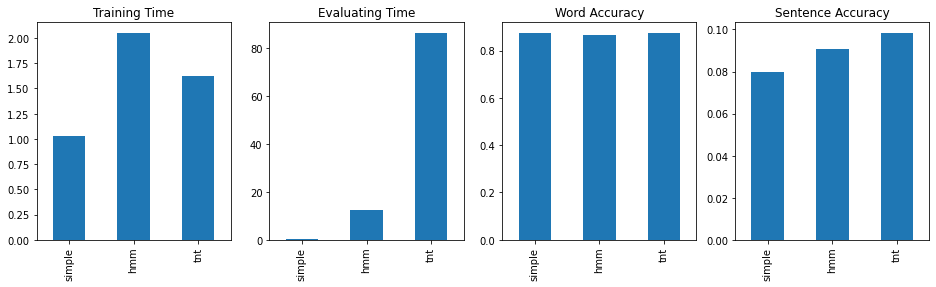

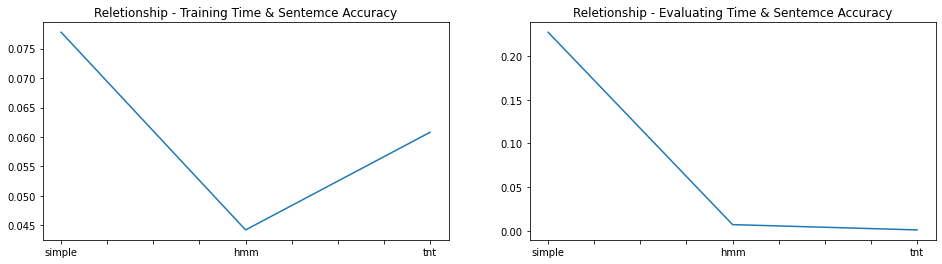

In [ ]:
df = pd.DataFrame(columns=results_st.keys())

df.loc['simple'] = results_st
df.loc['hmm'] = results_hmm
df.loc['tnt'] = results_tnt

cols = df.columns
# cols = ['Word Accuracy', 'Sentence Accuracy','Training time', 'Evaluating time']

print(tabulate(df, headers='keys', tablefmt='psql'))

figure, axes = plt.subplots(1, 4,figsize=(16,4))
for c in range(len(cols)):
    df[cols[c]].plot.bar(title=cols[c],ax=axes[c])
plt.show()


figure, axes = plt.subplots(1, 2,figsize=(16,4))
(df[cols[3]]/df[cols[0]]).plot(title='Reletionship - Training Time & Sentemce Accuracy',ax=axes[0])
(df[cols[3]]/df[cols[1]]).plot(title='Reletionship - Evaluating Time & Sentemce Accuracy',ax=axes[1])

plt.show()

## Conclusions

- Although `tnt` has the extrimly high evaluation time, it has the best accuracy results.  

- If I had constraints regarding response time I would choose `hmm`, which has almost as good results as `tnt`, but has a fast response.

- Obviously, if complexity&time is an issue I would go for the `simple` tagger, which is easy to explain and expirement with. For example, If I'l try a bigram/trigram with a `simple` tagger, I can only assume(!) at this point, but I would guess it will give almost as good results as the later. 


<br><br><br>
<br><br><br>
<br><br><br>

## Note 
Durring coding I had to expiremnt with another way of creating the tagger.  
As we know, the tagger gives a random tag to unseen words. 
This way adds a lot of complexity to the model, and a lot of assumptions, due to each sequance starts again with a pi.
The main dissadantage is the "loss" of information in each time we "cut off" the sequance.

Thus, I wanted to expirement with a different method.   
I will note that I know the results will not be as good as the method mentioned above, but I had to expiremnt in this manner, and check "how different" will the results be, If I wil not "cut off" the sequance in case of an unseen word.  

So, as before, an unseen word will get a random tag, but...  
I will "feed" the viterbi the whole seqaunce at once. Then, for each sentence I will have only one viterbi computation. 

In [ ]:
class my_hmm_tagger:
  
    def get_word_map_and_tag_map(self,data):
        '''
        Input: treebank sentences
        Output: 
                word_map - dict with all counters of tags
                tag_map - count tags appearances
        '''
        word_map = {}
        tag_map = {}

        for sentence in data:
            for word,tag in sentence:

                # WORD_MAP
                if word not in word_map:
                    word_map[word] = {'id':len(word_map),'tags':{}}


                if tag in word_map[word]['tags']:
                    word_map[word]['tags'][tag] += 1
                else:
                    word_map[word]['tags'][tag] = 1

                # TAG_MAP
                if tag not in tag_map:
                    tag_map[tag] = {'id':len(tag_map),'count':1}
                else:
                    tag_map[tag]['count'] += 1

        return word_map,tag_map

    # Viterbi
    def viterbi(self,word_list):

        A=self.A
        B=self.B
        Pi=self.pi
        
        # initialization
        T = len(word_list)
        N = A.shape[0] # number of tags

        delta_table = np.zeros((N, T)) # initialise delta table
        psi = np.zeros((N, T))  # initialise the best path table

        delta_table[:,0] = B[:, word_list[0]] * Pi

        for t in range(1, T):
            for s in range (0, N):
                trans_p = delta_table[:, t-1] * A[:, s]
                psi[s, t], delta_table[s, t] = max(enumerate(trans_p), key=operator.itemgetter(1))
                delta_table[s, t] = delta_table[s, t] * B[s, word_list[t]]

        # Back tracking
        seq = np.zeros(T);
        seq[T-1] =  delta_table[:, T-1].argmax()
        for t in range(T-1, 0, -1):
    #       print(seq[t])
          seq[t-1] = psi[int(seq[t]),t]

        return seq
    
    def train(self, data):
    # TODO

        # unique
        word_map,tag_map = self.get_word_map_and_tag_map(data)

        # word_map
        unique_word_map_id = list([word_map[word]['id'] for word in word_map])

        # create pi
        tag_map_values = np.array([tag['count'] for tag in tag_map.values() ])
        pi = tag_map_values / tag_map_values.sum()

        # create B
        B = np.zeros((len(tag_map),len(word_map)))
        for word in word_map.values():
            for tag in word['tags']:
                B[tag_map[tag]['id'],word['id']] = word['tags'][tag]
        B = B / B.sum(axis=1)[:, np.newaxis]

        # create A
        A = np.zeros((len(tag_map),len(tag_map)))
        for sentence in train_data:
            for current_word,next_word in zip(sentence[:-1],sentence[1:]):
                A[tag_map[current_word[1]]['id'],tag_map[next_word[1]]['id']] += 1
        A = A / A.sum(axis=1)[:,np.newaxis]

        # mapping ID to WORD
        from_id_to_word = {word_map[word]['id']:word for word in word_map.keys()}

        # mapping ID to TAG
        from_id_to_tag = {tag_map[tag]['id']:tag for tag in tag_map}

        # init params
        self.word_map = word_map
        self.tag_map = tag_map
        self.unique_word_map_id = unique_word_map_id
        self.from_id_to_word = from_id_to_word
        self.from_id_to_tag = from_id_to_tag
        self.A = A
        self.B = B
        self.pi = pi
    

    def evaluate(self, data):
    # TODO
        # choose only exists ids 

        word_true = 0
        word_count = 0
        sentence_true = 0

        for sentence in data:

            words = np.random.choice(self.unique_word_map_id,size=len(sentence))
            tags = [None] * len(sentence)

            for i in range(len(sentence)): 

                word,tag = sentence[i]

                if word in self.word_map.keys():
                    words[i] = self.word_map[word]['id']
                # else: already has an random number

                tags[i] = tag
            
            result = self.viterbi(words)
            result = [self.from_id_to_tag.get(r) for r in result]

            word_true += np.sum([r==t for r,t in zip(result,tags)])
            word_count += len(sentence) 
            
            if np.sum([r==t for r,t in zip(result,tags)]) == len(sentence):
                sentence_true += 1

        return word_true/word_count,sentence_true/len(data)
    
    
    def get_results(self,train_data,test_data):
        r = {}
        
        r['Training Time'] = time()
        self.train(train_data)
        r['Training Time'] = time() - r['Training Time']
        
        r['Evaluating Time'] = time()
        r['Word Accuracy'], r['Sentence Accuracy'] = self.evaluate(test_data)
        r['Evaluating Time'] = time() - r['Evaluating Time']
        
        return r

my_hmm = my_hmm_tagger()
results_my_hmm = my_hmm.get_results(train_data,test_data)

+--------+-----------------+-------------------+-----------------+---------------------+
|        |   Training Time |   Evaluating Time |   Word Accuracy |   Sentence Accuracy |
|--------+-----------------+-------------------+-----------------+---------------------|
| hmm    |         2.05287 |           12.6099 |        0.864451 |           0.0908096 |
| my_hmm |         2.10334 |           16.1515 |        0.797626 |           0.105033  |
+--------+-----------------+-------------------+-----------------+---------------------+


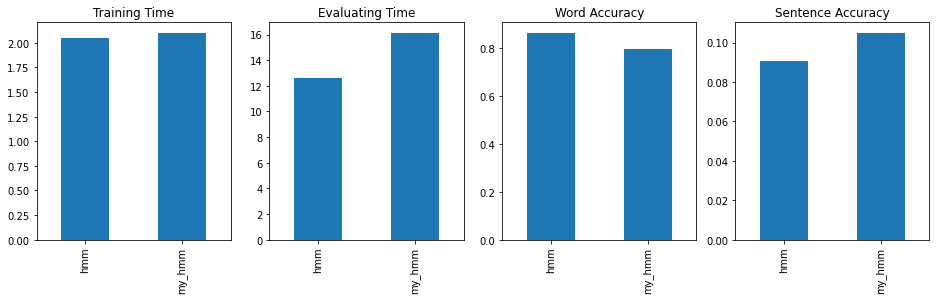

In [ ]:
df = pd.DataFrame(columns=results_st.keys())

df.loc['hmm'] = results_hmm
df.loc['my_hmm'] = results_my_hmm

print(tabulate(df, headers='keys', tablefmt='psql'))

# print(tabulate(df, headers='keys', tablefmt='psql'))

figure, axes = plt.subplots(1, 4,figsize=(16,4))
for c in range(len(cols)):
    df[cols[c]].plot.bar(title=cols[c],ax=axes[c])
plt.show()

### Conclusions

As I mention, I assumed that "my_hmm" model will not better then the "hmm" model.
Sadly, the training time and evaluating time is higher. I thought that all the splits, append and checks will take more time then multiplying the matrix "few more times". maybe if I would load the calculation to the GPC. maybe..

Obvoisly, as expected, the word accuracy is lowwer due to giving the unseen words a random value, but using the initial pi every time (we caculated pi based on frequency in trainset).

But, and this is the big one - How is it that the sentence accuracy is higher in "my_hmm"? still trying to figure it out :)))